# Digit AI Trainer
#### How-to:
- Paste function into last cell
- Run all cells

In [17]:
import torch
from fastai.vision.all import *
import logging
import time
import numpy as np
from sklearn.metrics import accuracy_score
import torch.nn as nn
from collections import OrderedDict


def summary(model, input_size, batch_size=-1, device="cuda"):
# Copied from torchsummary
    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. )
    total_output_size = abs(2. * total_output * 4. )  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4.)
    estimated_size = total_params_size + total_output_size + total_input_size

    # total_size_str = "Estimated Total Size (MB): %0.2f" % total_size
    return estimated_size

def format_elapsed_time(start_time, end_time):
    # Calculate the time difference in seconds
    delta_time = end_time - start_time

    # Convert to minutes and hours if necessary
    if delta_time >= 3600:  # If delta_time is greater than or equal to 1 hour
        hours = int(delta_time // 3600)
        delta_time %= 3600
    else:
        hours = 0

    if delta_time >= 60:  # If delta_time is greater than or equal to 1 minute
        minutes = int(delta_time // 60)
        delta_time %= 60
    else:
        minutes = 0

    seconds = delta_time  # Remaining time in seconds
    formatted_seconds = f"{seconds:.2f}"  # Format seconds with 2 decimal places

    # Construct and return the formatted string
    return f"{hours} hours, {minutes} minutes, {formatted_seconds} seconds"

def save_confusion_matrix(interp, pic_path, cmap:str="Blues"):
    title = "Confusion Matrix (Training)"
    "Plot the confusion matrix, with `title` and using `cmap`."
    # This function is mainly copied from the sklearn docs
    cm = interp.confusion_matrix()
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(interp.vocab))
    plt.xticks(tick_marks, interp.vocab, rotation=90)
    plt.yticks(tick_marks, interp.vocab, rotation=0)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white"
                    if cm[i, j] > thresh else "black")

    ax = fig.gca()
    ax.set_ylim(len(interp.vocab)-.5,-.5)

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)
    fig.savefig(pic_path)

class ResizeTransform(Transform):
    def __init__(self, size):
        self.size = size
        
    def encodes(self, img: TensorImage):
        return img.resize(self.size)

def train_model(digit_folder="Projects/digit/digits", batch_size=32, epochs=12, seed=69, lr=3e-3, model_output="Projects/digit/models.pkl", save_conf=False, conf_out='None', base_model="resnet18"):
    # Logging
    torch.cuda.empty_cache()
    log_name = model_output.replace(".pkl", ".txt")
    logging.getLogger().handlers = []
    logging.basicConfig(level=logging.INFO)
    file_handler = logging.FileHandler(log_name)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', '%H:%M:%S')
    file_handler.setFormatter(formatter)
    logging.getLogger().addHandler(file_handler)
    with open(log_name, 'w'):
        pass
    logging.info('Logger setup')
    
    # Setup device
    available = torch.cuda.is_available()
    logging.info(f'CUDA: {available}')
    device = torch.device('cuda' if available else 'cpu')
    if available:
        logging.info(f"Device: {torch.cuda.get_device_name(device)}")
    else:
        logging.info("Using CPU")

    model_map = {
        'AlexNet': models.alexnet,
        'DenseNet121': models.densenet121,
        'EfficientNet_b0': models.efficientnet_b0,
        'GoogleNet': models.googlenet,
        'MobileNet_v3_small': models.mobilenet_v3_small,
        'ResNet18': models.resnet18,
        'ResNet50': models.resnet50,
        'SqueezeNet1_0': models.squeezenet1_0,
        'SqueezeNet1_1': models.squeezenet1_1,
        'VGG13_bn': models.vgg13_bn,
    }

    arch = model_map[base_model]

    logging.info(f'Base model architecture: {base_model}')

    # Load data, set seed, augment training photos
    set_seed(seed)

    logging.info(f'Seed: {seed}')

    fingers = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(),
        get_y=parent_label,
        batch_tfms=aug_transforms(mult = 1.5,max_zoom=1.),
        item_tfms=[Resize(size=(640, 480), method="squish")])
    
    logging.info(f'DataBlock created')

    dls = fingers.dataloaders(digit_folder, batch_size=batch_size)

    logging.info(f'DataLoader created')

    # Create classifier
    learn = vision_learner(dls, arch, metrics=error_rate, lr=lr)
    learn.model.to(device)

    logging.info(f'Learner created on {device}')

    logging.info(f'Training started: \n\tNumber of epochs = {epochs} \n\tBatch size = {batch_size} \n\tLearning rate = {lr}')
    time1 = time.time()

    # Check estimated memory usage
    if available:
        device_properties = torch.cuda.get_device_properties(0)
        device_memory = device_properties.total_memory
        logging.info(f"Device memory: {device_memory / 1024**2:.1f} MB")
    try: # error raised when using DenseNet or CUDA not available
        est_mem = summary(arch().cuda(), (3, 480, 640), batch_size=batch_size)
        if est_mem > device_memory:
            logging.info(f"Estimated Total Size: {est_mem / 1024**2:.2f} MB")
            logging.warning("Estimated memory usage is larger than device's memory")
    except Exception as e:
        logging.error(e)
        logging.warning("Could not estimate estimated memory usage")

    # Train classifier
    try:
        learn.fine_tune(epochs)
        torch.cuda.empty_cache()
    except:
        learn = None
        logging.error("Failed to train model")
        exit()

    time2 = time.time()
    dt = format_elapsed_time(time1, time2)
    logging.info(f'Training finished \n\tTime taken = {dt}')

    if available:
        mem_stats = torch.cuda.memory_stats(device=device)
        logging.info(f"Total memory allocated = {mem_stats['active_bytes.all.allocated'] / 1024**3 :.2f} GB")
        logging.info(f"Peak memory allocated = {mem_stats['active_bytes.all.peak'] / 1024**3 :.2f} GB")
        logging.info(f"Current memory allocated = {mem_stats['active_bytes.all.current']  / 1024**3 :.2f} GB")
        torch.cuda.reset_peak_memory_stats(device=device)
        torch.cuda.reset_accumulated_memory_stats(device=device)

    # Analyze classifier
    if save_conf:
        interp = ClassificationInterpretation.from_learner(learn)
        save_confusion_matrix(interp, conf_out)
        logging.info(f'Confusion matrix: \n{interp.confusion_matrix()}')

    # Accuracy score
    preds, targets = learn.get_preds(dl=dls.valid)
    acc = accuracy_score(targets.numpy(), np.argmax(preds, axis=1))
    logging.info(f'Validation accuracy = {acc:.3f}')

    # Export model
    # Check if file name ends in .pkl
    if not model_output.endswith(".pkl"):
            model_output += ".pkl"

    learn.export(fname=model_output)

    # Close logging
    logging.info("Exiting logger")
    file_handler.close()

##### Paste code into cell below

INFO:root:Logger setup
INFO:root:CUDA: True
INFO:root:Device: NVIDIA GeForce RTX 3070
INFO:root:Base model architecture: ResNet18
INFO:root:Seed: 69
INFO:root:DataBlock created
INFO:root:DataLoader created
INFO:root:Learner created on cuda
INFO:root:Training started: 
	Number of epochs = 12 
	Batch size = 8 
	Learning rate = 3e-05
INFO:root:Device memory: 8191.5 MB


epoch,train_loss,valid_loss,error_rate,time
0,3.165812,2.398845,0.780000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,2.539524,2.100574,0.780000,00:02
1,2.571410,2.015964,0.680000,00:02
2,2.386259,2.042937,0.740000,00:02
3,2.308192,2.138629,0.660000,00:02
4,2.223361,2.237940,0.800000,00:02
5,2.138587,2.366496,0.820000,00:02
6,2.095291,2.515285,0.760000,00:02
7,2.090689,2.551919,0.780000,00:02
8,2.075072,2.549940,0.780000,00:02
9,1.967494,2.519663,0.780000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.541306,2.631806,0.780000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.651043,2.536831,0.760000,00:02
1,1.772627,2.426768,0.780000,00:02
2,1.653700,2.376718,0.740000,00:02
3,1.642634,2.336815,0.760000,00:02
4,1.672859,2.491021,0.720000,00:02
5,1.602508,2.521709,0.700000,00:02
6,1.566426,2.464253,0.700000,00:02
7,1.528842,2.399820,0.740000,00:02
8,1.464032,2.258013,0.620000,00:02
9,1.410870,2.176819,0.620000,00:02


INFO:root:Training finished 
	Time taken = 0 hours, 1 minutes, 2.79 seconds
INFO:root:Total memory allocated = 2203.90 GB
INFO:root:Peak memory allocated = 2.74 GB
INFO:root:Current memory allocated = 0.33 GB


INFO:root:Confusion matrix: 
[[4 4 1 1 0]
 [4 5 1 0 0]
 [0 1 5 1 3]
 [2 4 1 0 3]
 [4 2 1 0 3]]


INFO:root:Validation accuracy = 0.340
INFO:root:Exiting logger


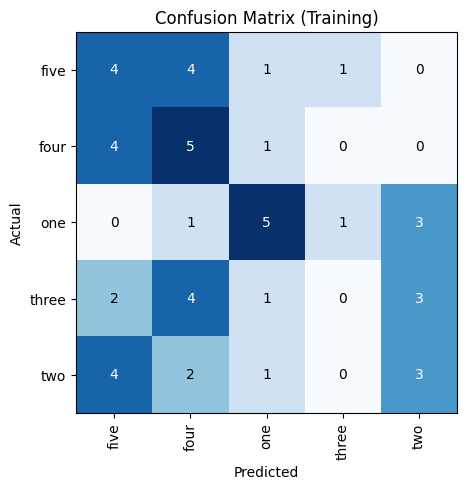

In [18]:
# Example: 
# train_model(digit_folder="Projects/digits_1.0/digits", batch_size=16, epochs=2, seed=69, lr=3e-05, model_output="Projects/digits_1.0/models/TEST.pkl", save_conf=True, conf_out="Projects/digits_1.0/results/TEST.png", base_model="AlexNet")

# Code used for DenseNet
# train_model(digit_folder="Projects/digits_2.0/digits", batch_size=8, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_2.0/models/DenseNet121.pkl", save_conf=True, conf_out="Projects/digits_2.0/results/DenseNet121.png", base_model="DenseNet121")

train_model(digit_folder="Projects\digits_4.0\digits", batch_size=8, epochs=12, seed=69, lr=3e-05, model_output="Projects/digits_4.0/models/DenseNet121.pkl", save_conf=True, conf_out="Projects/digits_4.0/results/DenseNet121.png", base_model="ResNet18")
